# Interday Stochastic Process

Interday stochastics does not work in practice. The term representing information, which is proportional to dt, is outwayed by the term representing random, due to dt approaching 0.


In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../..')

## Data Aquisition

Download some large number of datapoints split into several datasets.

In [2]:
import priceanalytics.data as data

big_df = data.alpaca_download_single(
    'MSFT',     
    past_days=30, 
    interval=1
)
dfs = data.split_alpaca_on_day(big_df)
print(sum([len(df) for df in dfs]))

/Users/justus/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


7410


Normalize the data and ensure no loss.

7410
6760 650


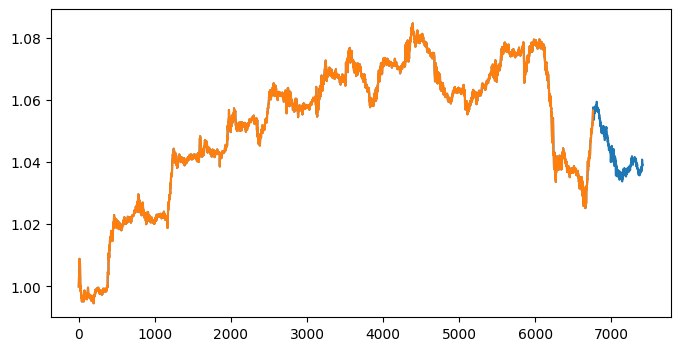

In [3]:
normalized = data.normalize_dataset(dfs, lambda df: df['close'].to_numpy())
print(len(normalized))

import pandas as pd
import numpy as np
import priceanalytics.plot as plot
import matplotlib.pyplot as plt

split = -650
sample = normalized[:split]
test = normalized[split:]

print(len(sample), len(test))

with plot.MultiPlot(1, size=(8, 4)) as m:
    
    plt.plot(normalized)
    plt.plot(sample)


## Log-Return Analysis 

Compute log-returns and plot.

datalen =  6760


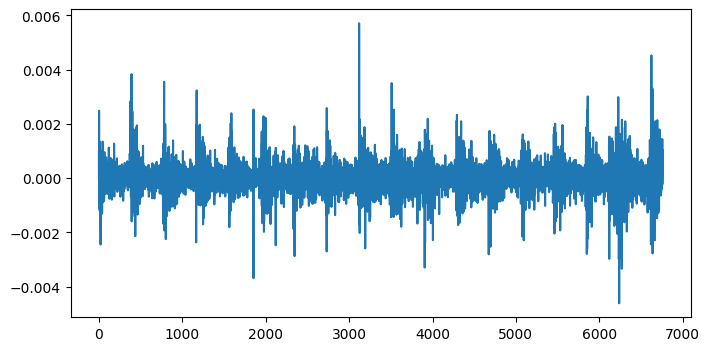

In [4]:
log_returns = np.diff(np.log(sample))

dlen = len(sample)
print("datalen = ", dlen)
    
with plot.MultiPlot(1, size=(8, 4)) as m:
    plt.plot(log_returns)

Model log-returns using the *student's t* distribution. 

In [5]:
import scipy

cvm = dlen # criticalvaluemultiplier

mu = log_returns.mean() * cvm
print("mu = ", mu)
sigma = log_returns.std() * (cvm**0.5)
print("sigma = ", sigma)

from scipy.stats import t as students_t

dof, loc, scale = students_t.fit(log_returns)
# mu, var, skew, kurt = t.stats(dof, moments='mvsk') 
# print(mu, var, skew, kurt)

# random = t.rvs(dof, loc=loc, scale=scale, size=len(log_returns))

def remove_outliers(l, B):
    minmax = lambda x: max(min(x, B), -B)  # remove outliers 
    return np.array([minmax(x) for x in l])
    
# random = remove_outliers(random, .00000000)

# with plot.MultiPlot(1, size=(8, 4)) as m:
#     plt.hist(log_returns, bins='auto', density=True)
#     plt.axvline(x=mu/nse, color='red', linestyle='--')
    # m.next()
    # plt.hist(random, bins='auto', density=True)

nse = len(test) # number of samples to extrapolate

S0 = sample[-1]
T = 1
dt = 1/252
inter = int(T/dt)

np.random.seed(20)
sims = 300
paths = np.zeros((inter+1, sims))
paths[0] = S0

for t in range(1, inter+1):
    # different random strategies
    # z_score = np.random.standard_normal(sims)
    z_score = scipy.stats.laplace.rvs(size=sims)
    # z_score = students_t.rvs(dof, loc=loc, scale=scale, size=sims)

    paths[t] = paths[t-1] * np.exp((mu-0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z_score)
    
def calc(paths, S0, mu, sigma, T):
    pts = paths[-1]
    scale = S0 * np.exp(mu * T)
    probabilities = scipy.stats.lognorm.pdf(pts, s=sigma * np.sqrt(T), scale=scale)
    return probabilities

probabilities = calc(paths, S0, mu, sigma, T)
normalized = probabilities / probabilities.max()
indices = np.argsort(normalized)
paths = paths[:, indices]
new_probabilities = normalized[indices]
d = (paths[-1] - S0).mean() / S0

mu =  0.05502952651594443
sigma =  0.04654700030419712


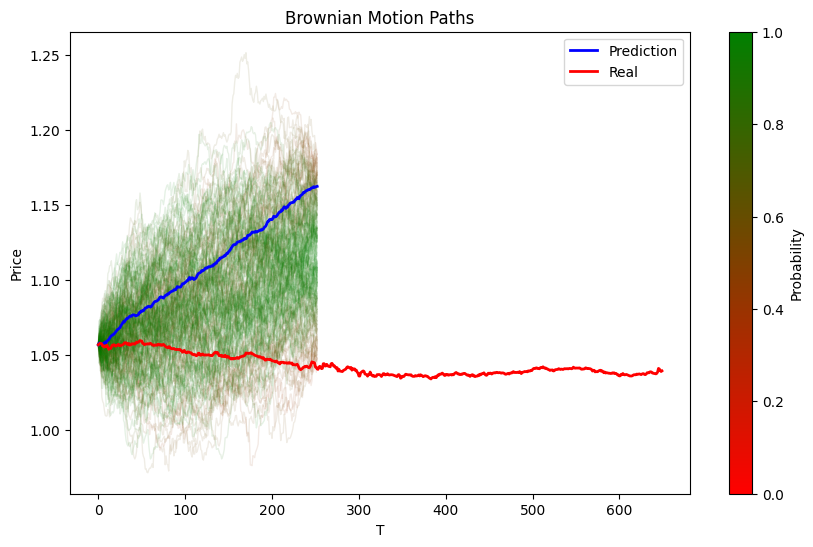

In [6]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.cm import ScalarMappable

consolidated_path = np.sum(((paths * new_probabilities) / 100), axis=1) + sample[-1]
consolidated_path -= consolidated_path[0]
consolidated_path += sample[-1]

lsc = LinearSegmentedColormap.from_list("RedToGreen", ["red", "green"])
fig, axis = plt.subplots(figsize=(10, 6))

for i in range(sims):
    prob = new_probabilities[i]
    if prob < .4: continue
    axis.plot(paths[:, i], lw=1, color=lsc(prob), alpha=0.1)


sm = ScalarMappable(cmap=lsc)
prob_bar = plt.colorbar(sm, ax=axis)
prob_bar.set_label('Probability')

axis.plot(consolidated_path, lw=2, color='blue', label='Prediction')
# axis.plot(test[:len(consolidated_path)], lw=2, color='orange', label='Real')
axis.plot(test, lw=2, color='red', label='Real')

axis.set_title('Brownian Motion Paths')
axis.set_xlabel('T')
axis.set_ylabel('Price')

plt.legend()
plt.show()

Dear Justus (future),

You must create a decision model which, when tested on a large set of random stochastic futures, is sufficeintly likely to produce a possitive return. 

Regards, 
Justus (past)

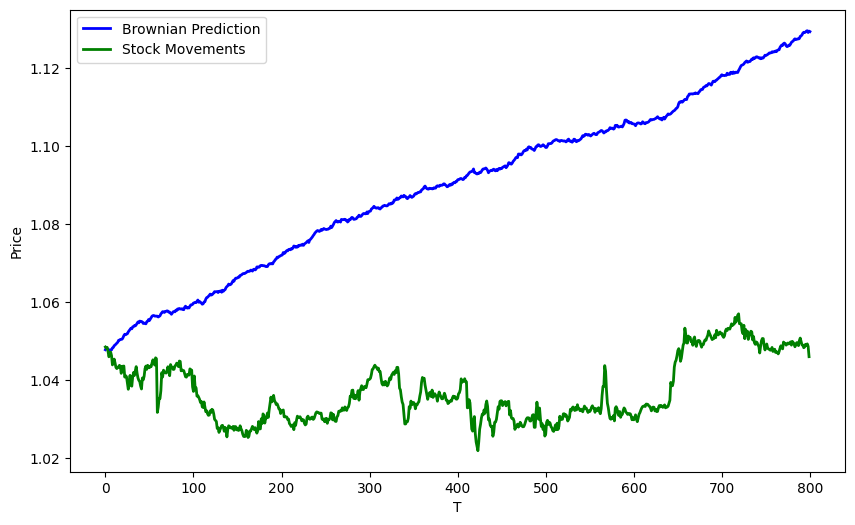

In [74]:
fig, axis = plt.subplots(figsize=(10, 6))

axis.plot(consolidated_path, lw=2, color='blue', label='Brownian Prediction')

axis.set_xlabel('T')
axis.set_ylabel('Price')

# aapl = yf.Ticker("AAPL")
# start_date = '2023-05-19'
# actual_data = aapl.history(start=start_date)
# actual_data.index = actual_data.index.tz_localize(None)
# actual_data['Days_Since'] = (actual_data.index - pd.Timestamp('2023-05-19')).days
# actual_data.reset_index(drop=True, inplace=True)

axis.plot(test, lw=2, color='green', label='Stock Movements')

plt.legend()
plt.show()